In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from utils import preprocess_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROB7824\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROB7824\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
text_df = pd.read_csv("./df_file.csv")

X = text_df['Text']
y = text_df['Label']

X_preprocessed = [preprocess_text(text) for text in X]

X_train, X_test, y_train, y_test = train_test_split(  X_preprocessed
                                                    , y
                                                    , test_size=0.2
                                                    , random_state=42)

In [4]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [5]:
#Export vectorizer
joblib.dump(vectorizer, "./vectorizer.pkl")

['./vectorizer.pkl']

In [9]:
# Define the XGBoost model for text classification
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42) #, tree_method = "hist", device = "cuda"

In [10]:
# Define the hyperparameter grid for random search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5]
}

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(  estimator=xgb_model
                                   , param_distributions=param_grid
                                   , n_iter=10
                                   , scoring='accuracy'
                                   , cv=kf
                                   , verbose=2
                                   , random_state=42
                                   , n_jobs=-1)

In [13]:
# Fit the model with random search using TF-IDF features
# Average runtime: 8 minutes
random_search.fit(X_train_tfidf, y_train)

print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [17]:
#Export model
joblib.dump(random_search, "./xgboost.pkl")

['./xgboost.pkl']

In [14]:
# Make predictions on the test set using the best model
y_pred = random_search.best_estimator_.predict(X_test_tfidf)

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

# Additional evaluation metrics (classification report)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9640449438202248
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        92
           1       0.97      0.99      0.98        98
           2       0.96      0.96      0.96        77
           3       0.96      0.96      0.96        76
           4       0.96      0.96      0.96       102

    accuracy                           0.96       445
   macro avg       0.96      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445



[[87  2  2  1  0]
 [ 0 97  0  0  1]
 [ 0  0 74  1  2]
 [ 1  1  0 73  1]
 [ 2  0  1  1 98]]


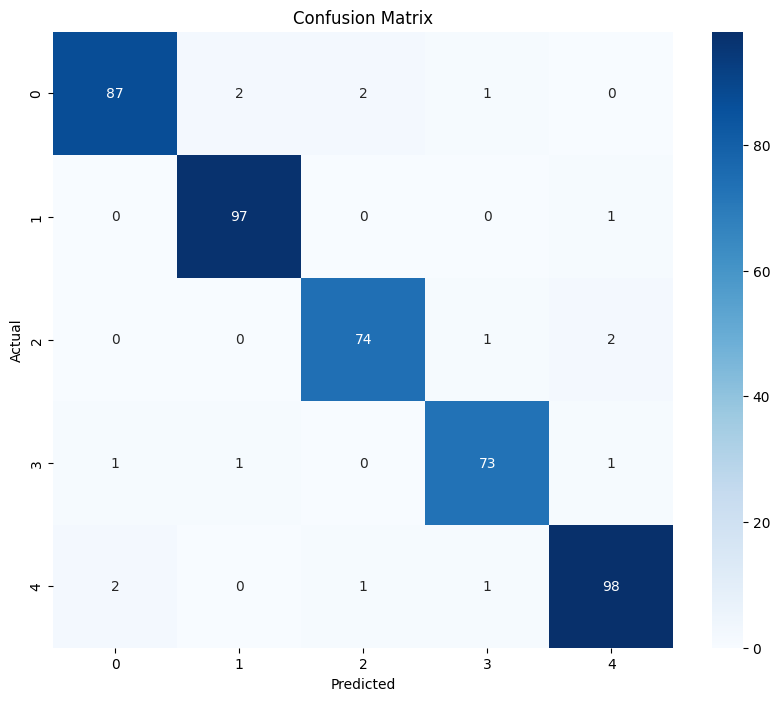

In [16]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Extract indices of misclassified instances
misclassified_indices = [i for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)) if true_label != pred_label]

# Extract misclassified instances
misclassified_data = text_df.iloc[misclassified_indices].copy()
misclassified_data['Predicted Label'] = y_pred[misclassified_indices]

In [15]:
# Display misclassified instances
print("Misclassified Instances:")
print(misclassified_data[['Text', 'Label', 'Predicted Label']])

Misclassified Instances:
                                                  Text  Label  Predicted Label
4    Kilroy names election seat target\r\n \r\n Ex-...      0                3
24   'Hitler' row over Welsh arts cash\r\n \r\n An ...      0                1
59   Blair backs 'pre-election budget'\r\n \r\n Ton...      0                2
85   What the election should really be about?\r\n ...      0                0
153  Labour targets 'hardcore truants'\r\n \r\n A f...      0                2
228  Taxes must be trusted - Kennedy\r\n \r\n Publi...      0                2
231  Sayeed to stand down as Tory MP\r\n \r\n Tory ...      0                1
235  Borders rail link campaign rally\r\n \r\n Camp...      0                0
306  Straw to attend Auschwitz service\r\n \r\n For...      0                1
310  Former NI minister Scott dies\r\n \r\n Former ...      0                0
318  Blair looks to election campaign\r\n \r\n Tony...      0                4
322  Wales 'must learn heal

In [16]:
# Load pre-trained XGBoost model
xgb_model = joblib.load("./xgboost.pkl")

# Load TF-IDF vectorizer
vectorizer = joblib.load("./vectorizer.pkl")

# Load test data
test_df = pd.read_csv("./TestDataUnseen.csv", delimiter=';')

# Transform text data using the TF-IDF vectorizer
text_tfidf = vectorizer.transform(test_df["Text"])

# Get predictions and confidence scores
predictions = xgb_model.predict(text_tfidf)
confidence_scores = xgb_model.predict_proba(text_tfidf)

# Define labels
labels = ["Politics", "Sport", "Technology", "Entertainment", "Business"]

# Format and print the results
for i, (prediction, confidence_score) in enumerate(zip(predictions, confidence_scores)):
    label = labels[prediction]
    confidence = confidence_score[prediction]
    print(f"Sample {i+1}:")
    print(f"  Prediction: {label}")
    print(f"  Confidence Score: {confidence:.2f}")
    print()

Sample 1:
  Prediction: Sport
  Confidence Score: 0.53

Sample 2:
  Prediction: Sport
  Confidence Score: 0.53

Sample 3:
  Prediction: Sport
  Confidence Score: 0.53

Sample 4:
  Prediction: Sport
  Confidence Score: 0.53

Sample 5:
  Prediction: Sport
  Confidence Score: 0.53

Sample 6:
  Prediction: Sport
  Confidence Score: 0.59

Sample 7:
  Prediction: Sport
  Confidence Score: 0.53

Sample 8:
  Prediction: Sport
  Confidence Score: 0.53

Sample 9:
  Prediction: Sport
  Confidence Score: 0.53

Sample 10:
  Prediction: Sport
  Confidence Score: 0.53

Sample 11:
  Prediction: Sport
  Confidence Score: 0.53

Sample 12:
  Prediction: Sport
  Confidence Score: 0.50

Sample 13:
  Prediction: Sport
  Confidence Score: 0.53

Sample 14:
  Prediction: Sport
  Confidence Score: 0.53

Sample 15:
  Prediction: Sport
  Confidence Score: 0.53

Sample 16:
  Prediction: Sport
  Confidence Score: 0.53

Sample 17:
  Prediction: Sport
  Confidence Score: 0.53

Sample 18:
  Prediction: Sport
  Confide